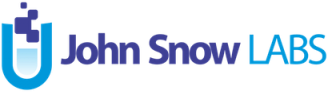

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/JohnSnowLabs/langtest/blob/main/demo/tutorials/misc/Augmentation_Control_Notebook.ipynb)

**LangTest** is an open-source python library designed to help developers deliver safe and effective Natural Language Processing (NLP) models. Whether you are using **John Snow Labs, Hugging Face, Spacy** models or **OpenAI, Cohere, AI21, Hugging Face Inference API and Azure-OpenAI** based LLMs, it has got you covered. You can test any Named Entity Recognition (NER), Text Classification model using the library. We also support testing LLMS for Question-Answering and Summarization tasks on benchmark datasets. The library supports 50+ out of the box tests. These tests fall into robustness, accuracy, bias, representation, toxicity and fairness test categories.

Metrics are calculated by comparing the model's extractions in the original list of sentences against the extractions carried out in the noisy list of sentences. The original annotated labels are not used at any point, we are simply comparing the model against itself in a 2 settings.

# Getting started with LangTest on John Snow Labs

In [ ]:
!pip install "langtest[johnsnowlabs,transformers]"

# Harness and its Parameters

The Harness class is a testing class for Natural Language Processing (NLP) models. It evaluates the performance of a NLP model on a given task using test data and generates a report with test results.Harness can be imported from the LangTest library in the following way.

In [2]:
#Import Harness from the LangTest library
from langtest import Harness

It imports the Harness class from within the module, that is designed to provide a blueprint or framework for conducting NLP testing, and that instances of the Harness class can be customized or configured for different testing scenarios or environments.

Here is a list of the different parameters that can be passed to the Harness function:

<br/>



| Parameter     | Description |
| ------------- | ----------- |
| **task**      | Task for which the model is to be evaluated (text-classification or ner) |
| **model**     | Specifies the model(s) to be evaluated. Can be a dictionary or a list of dictionaries. Each dictionary should contain 'model' and 'hub' keys. If a path is specified, the dictionary must contain 'model' and 'hub' keys. |
| **data**      | The data to be used for evaluation. A dictionary providing flexibility and options for data sources. It should include the following keys: <ul><li>data_source (mandatory): The source of the data.</li><li>subset (optional): The subset of the data.</li><li>feature_column (optional): The column containing the features.</li><li>target_column (optional): The column containing the target labels.</li><li>split (optional): The data split to be used.</li></ul> |
| **config**    | Configuration for the tests to be performed, specified in the form of a YAML file. |


<br/>
<br/>

# Real-World Project Workflows

In this section, we dive into complete workflows for using the model testing module in real-world project settings.

## Robustness Testing

In this example, we will be testing a model's robustness. We will be applying 2 tests: add_typo and lowercase. The real-world project workflow of the model robustness testing and fixing in this case goes as follows:

1. Train NER model on original CoNLL training set

2. Test NER model robustness on CoNLL test set

3. Augment CoNLL training set based on test results

4. Train new NER model on augmented CoNLL training set

5. Test new NER model robustness on the CoNLL test set from step 2

6. Compare robustness of new NER model against original NER model

#### Load Train and Test CoNLL

In [3]:
# Load test CoNLL
!wget https://raw.githubusercontent.com/JohnSnowLabs/langtest/main/langtest/data/conll/sample.conll

# Load train CoNLL
!wget https://raw.githubusercontent.com/JohnSnowLabs/langtest/main/demo/data/conll03.conll

--2023-08-18 07:27:31--  https://raw.githubusercontent.com/JohnSnowLabs/langtest/main/langtest/data/conll/sample.conll
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.111.133, 185.199.109.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.110.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 50519 (49K) [text/plain]
Saving to: ‘sample.conll’

sample.conll        100%[===================>]  49.33K  --.-KB/s    in 0.006s  

2023-08-18 07:27:31 (7.50 MB/s) - ‘sample.conll’ saved [50519/50519]

--2023-08-18 07:27:31--  https://raw.githubusercontent.com/JohnSnowLabs/langtest/main/demo/data/conll03.conll
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 827443 (

#### Step 1: Train NER Model

In [4]:
from johnsnowlabs import nlp

In [5]:
ner_model = nlp.load('bert train.ner').fit(dataset_path="/content/conll03.conll")


small_bert_L2_128 download started this may take some time.
Approximate size to download 16.1 MB
[OK!]


#### Step 2: Test NER Model Robustness  

In [6]:
harness = Harness(task="ner", model={"model": ner_model, "hub": "johnsnowlabs"}, data={"data_source":"sample.conll"})

Test Configuration : 
 {
 "tests": {
  "defaults": {
   "min_pass_rate": 1.0
  },
  "robustness": {
   "add_typo": {
    "min_pass_rate": 0.7
   },
   "american_to_british": {
    "min_pass_rate": 0.7
   }
  },
  "accuracy": {
   "min_micro_f1_score": {
    "min_score": 0.7
   }
  },
  "bias": {
   "replace_to_female_pronouns": {
    "min_pass_rate": 0.7
   },
   "replace_to_low_income_country": {
    "min_pass_rate": 0.7
   }
  },
  "fairness": {
   "min_gender_f1_score": {
    "min_score": 0.6
   }
  },
  "representation": {
   "min_label_representation_count": {
    "min_count": 50
   }
  }
 }
}


In [7]:
harness.configure({
    'tests': {
        'defaults': {'min_pass_rate': 0.65},

        'robustness': {
            'add_typo': {'min_pass_rate': 0.65},
            'lowercase':{'min_pass_rate': 0.65},
        }
    }
})

{'tests': {'defaults': {'min_pass_rate': 0.65},
  'robustness': {'add_typo': {'min_pass_rate': 0.65},
   'lowercase': {'min_pass_rate': 0.65}}}}

Here we have configured the harness to perform two robustness tests (add_typo and lowercase) and defined the minimum pass rate for each test.


#### Generating the test cases.




In [8]:
harness.generate()

Generating testcases...: 100%|██████████| 1/1 [00:00<00:00, 5412.01it/s]


harness.generate() method automatically generates the test cases (based on the provided configuration)

In [9]:
harness.testcases()

category  test_type                                           original  \
0    robustness   add_typo  SOCCER - JAPAN GET LUCKY WIN , CHINA IN SURPRI...   
1    robustness   add_typo                                        Nadim Ladki   
2    robustness   add_typo           AL-AIN , United Arab Emirates 1996-12-06   
3    robustness   add_typo  Japan began the defence of their Asian Cup tit...   
4    robustness   add_typo  But China saw their luck desert them in the se...   
..          ...        ...                                                ...   
447  robustness  lowercase                    Portuguesa 1 Atletico Mineiro 0   
448  robustness  lowercase     CRICKET - LARA ENDURES ANOTHER MISERABLE DAY .   
449  robustness  lowercase                                      Robert Galvin   
450  robustness  lowercase                               MELBOURNE 1996-12-06   
451  robustness  lowercase  Australia gave Brian Lara another reason to be...   

                                             test_case  
0    SOCCER - JAPAN GET LUCKY WIN , CHINA IN SYRPRI...  
1                                          Nadim Oadki  
2             AL-AIN , United Arab Emirates1 996-12-06  
3    Japan began the defence of their Asian Cup tit...  
4    But China saw their luck desert them in the se...  
..                                                 ...  
447                    portuguesa 1 atletico mineiro 0  
448     cricket - lara endures another miserable day .  
449                                      robert galvin  
450                               melbourne 1996-12-06  
451  australia gave brian lara another reason to be...  

[452 rows x 4 columns]

harness.testcases() method gives the produced test cases in form of a pandas data frame.

#### Saving test configurations, data, test cases

In [10]:
harness.save("saved_test_configurations")

#### Running the tests

In [11]:
harness.run()

Running testcases... : 100%|██████████| 452/452 [01:22<00:00,  5.45it/s]


Called after harness.generate() and is to used to run all the tests.  Returns a pass/fail flag for each test.

In [12]:
harness.generated_results()

category  test_type                                           original  \
0    robustness   add_typo  SOCCER - JAPAN GET LUCKY WIN , CHINA IN SURPRI...   
1    robustness   add_typo                                        Nadim Ladki   
2    robustness   add_typo           AL-AIN , United Arab Emirates 1996-12-06   
3    robustness   add_typo  Japan began the defence of their Asian Cup tit...   
4    robustness   add_typo  But China saw their luck desert them in the se...   
..          ...        ...                                                ...   
447  robustness  lowercase                    Portuguesa 1 Atletico Mineiro 0   
448  robustness  lowercase     CRICKET - LARA ENDURES ANOTHER MISERABLE DAY .   
449  robustness  lowercase                                      Robert Galvin   
450  robustness  lowercase                               MELBOURNE 1996-12-06   
451  robustness  lowercase  Australia gave Brian Lara another reason to be...   

                                             test_case  \
0    SOCCER - JAPAN GET LUCKY WIN , CHINA IN SYRPRI...   
1                                          Nadim Oadki   
2             AL-AIN , United Arab Emirates1 996-12-06   
3    Japan began the defence of their Asian Cup tit...   
4    But China saw their luck desert them in the se...   
..                                                 ...   
447                    portuguesa 1 atletico mineiro 0   
448     cricket - lara endures another miserable day .   
449                                      robert galvin   
450                               melbourne 1996-12-06   
451  australia gave brian lara another reason to be...   

                                expected_result  \
0            japan: LOC, lucky: LOC, china: LOC   
1                              nadim ladki: PER   
2        al-ain: LOC, united arab emirates: LOC   
3           japan: LOC, asian: MISC, syria: LOC   
4                   china: LOC, uzbekistan: LOC   
..                                          ...   
447      portuguesa: ORG, atletico mineiro: ORG   
448                                   lara: PER   
449                          robert galvin: PER   
450                              melbourne: LOC   
451  australia: LOC, brian lara: PER, west: LOC   

                                  actual_result   pass  
0            japan: LOC, lucky: LOC, china: LOC   True  
1                              nadim oadki: PER   True  
2       al-ain: LOC, united arab emirates1: LOC  False  
3           japan: LOC, asian: MISC, syria: LOC   True  
4                   china: LOC, uzbekisyan: LOC   True  
..                                          ...    ...  
447      portuguesa: ORG, atletico mineiro: ORG   True  
448                                   lara: PER   True  
449                          robert galvin: PER   True  
450                              melbourne: LOC   True  
451  australia: LOC, brian lara: PER, west: LOC   True  

[452 rows x 7 columns]

This method returns the generated results in the form of a pandas dataframe, which provides a convenient and easy-to-use format for working with the test results. You can use this method to quickly identify the test cases that failed and to determine where fixes are needed.

#### Report of the tests

In [13]:
harness.report()

category  test_type  fail_count  pass_count pass_rate minimum_pass_rate  \
0  robustness   add_typo          73         153       68%               65%   
1  robustness  lowercase           0         226      100%               65%   

   pass  
0  True  
1  True

It summarizes the results giving information about pass and fail counts and overall test pass/fail flag.

#### Step 3: Augment CoNLL Training Set Based on Robustness Test Results

**Augumentation with custom proportions in Dict format**

custom_proportions is a dictionary with augmentation on test type as key and proportion as value. The proportion is the percentage of the test cases that will be augmented with the given augmentation type.

```
custom_proportions = {'add_typo': 0.5, 'lowercase': 0.5}
```

**Augumentation with custom proportions in List format**

custom_proportions is a list of test types.
```
custom_proportions = ['add_typo', 'lowercase']
```

The `.augment()` function takes the following parameters:

1. `training_data` (dict): (Required) Specifies the source of the original training data. It should be a dictionary containing the necessary information about the dataset.
    - Example: `{"data_source": "conll03.conll"}`

2. `save_data_path` (str): (Required) Name of the file to store the augmented data. The augmented dataset will be saved in this file.
    - Example: `augmented_conll03.conll`

3. `custom_proportions` (dict): (Required) custom_proportions is a dictionary with augmentation on test type as key and proportion as value. The proportion is the percentage of the test cases that will be augmented with the given augmentation type.
    - Example: `{"add_typo": 0.3, "lowercase": 0.3}`

4. `export_mode` (str): (Optional) Specifies how the augmented data should be exported. The possible values are:
    - `'inplace'`: Modifies the list of samples in place.
    - `'add'`: Adds new samples to the input data.
    - `'transformed'`: Exports only the transformed data, excluding different untransformed samples.
    - Example: `"transformed"`


In [14]:
custom_proportions = {
    'add_typo':0.3,
    'lowercase':0.3
}

data_kwargs = {
      "data_source" : "conll03.conll",
       }

harness.augment(
    training_data = data_kwargs,
    save_data_path ="augmented_conll03.conll",
    custom_proportions=custom_proportions,
    export_mode="transformed")

Essentially it applies perturbations to the input data based on the recommendations from the harness reports. Then this augmented_dataset is used to retrain the original model so as to make the model more robust and improve its performance.

#### Step 4: Train New NER Model on Augmented CoNLL

In [15]:
augmented_ner_model = nlp.load('bert train.ner').fit(dataset_path= "augmented_conll03.conll")

small_bert_L2_128 download started this may take some time.
Approximate size to download 16.1 MB
[OK!]


#### Load saved test configurations, data

In [16]:
harness = Harness.load("saved_test_configurations",model=augmented_ner_model, task="ner")

Test Configuration : 
 {
 "tests": {
  "defaults": {
   "min_pass_rate": 0.65
  },
  "robustness": {
   "add_typo": {
    "min_pass_rate": 0.65
   },
   "lowercase": {
    "min_pass_rate": 0.65
   }
  }
 }
}


Generating testcases...: 100%|██████████| 1/1 [00:00<00:00, 1476.35it/s]


#### Step 5: Test New NER Model Robustness

In [17]:
harness.run()

Running testcases... : 100%|██████████| 452/452 [01:12<00:00,  6.25it/s]


In [18]:
harness.generated_results()

category  test_type                                           original  \
0    robustness   add_typo  SOCCER - JAPAN GET LUCKY WIN , CHINA IN SURPRI...   
1    robustness   add_typo                                        Nadim Ladki   
2    robustness   add_typo           AL-AIN , United Arab Emirates 1996-12-06   
3    robustness   add_typo  Japan began the defence of their Asian Cup tit...   
4    robustness   add_typo  But China saw their luck desert them in the se...   
..          ...        ...                                                ...   
447  robustness  lowercase                    Portuguesa 1 Atletico Mineiro 0   
448  robustness  lowercase     CRICKET - LARA ENDURES ANOTHER MISERABLE DAY .   
449  robustness  lowercase                                      Robert Galvin   
450  robustness  lowercase                               MELBOURNE 1996-12-06   
451  robustness  lowercase  Australia gave Brian Lara another reason to be...   

                                             test_case  \
0    SOCCER - JAPAN GET LUCMY WIN , CHINA IN SURPRI...   
1                                          Madim Ladki   
2             AL-AIN , United Atab Emirates 1996-12-06   
3    Japan began the defence of yheir Asian Cup tit...   
4    But China saw thsir luck desert them in the se...   
..                                                 ...   
447                    portuguesa 1 atletico mineiro 0   
448     cricket - lara endures another miserable day .   
449                                      robert galvin   
450                               melbourne 1996-12-06   
451  australia gave brian lara another reason to be...   

                                  expected_result  \
0                          japan: LOC, china: LOC   
1                                nadim ladki: PER   
2    al-ain: LOC, united: LOC, arab emirates: LOC   
3             japan: LOC, asian: MISC, syria: LOC   
4                     china: LOC, uzbekistan: LOC   
..                                            ...   
447        portuguesa: ORG, atletico mineiro: ORG   
448                                                 
449                            robert galvin: PER   
450                                melbourne: LOC   
451               australia: LOC, brian lara: PER   

                                       actual_result   pass  
0                 japan: LOC, lucmy: PER, china: LOC   True  
1                                   madim ladki: PER   True  
2             al-ain: LOC, united atab emirates: LOC  False  
3    japan: LOC, yheir: LOC, asian: MISC, syria: LOC   True  
4                        china: LOC, uzbekistan: LOC   True  
..                                               ...    ...  
447           portuguesa: ORG, atletico mineiro: ORG   True  
448                                                    True  
449                               robert galvin: PER   True  
450                                   melbourne: LOC   True  
451                  australia: LOC, brian lara: PER   True  

[452 rows x 7 columns]

In [19]:
harness.report()

category  test_type  fail_count  pass_count pass_rate minimum_pass_rate  \
0  robustness   add_typo          71         155       69%               65%   
1  robustness  lowercase           0         226      100%               65%   

   pass  
0  True  
1  True


We can see that after performing augmentation, pass_rate for **add_typo** test is increased.

# HuggingFace Dataset Augmentation for Text Classification

### Installing required dependencies

In [ ]:
!pip install datasets

### Setup and Configure Harness

In [21]:
harness = Harness(task="text-classification",
                  model={"model":"distilbert-base-uncased-finetuned-sst-2-english", "hub":"huggingface"},
                  data={"data_source":'glue',
                  "subset":"sst2",
                  "feature_column":"sentence",
                  "target_column":'label',
                  "split":"train",
                  "source": "huggingface"
                  })

Generating train split:   0%|          | 0/67349 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/872 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/1821 [00:00<?, ? examples/s]

Map:   0%|          | 0/67349 [00:00<?, ? examples/s]

Test Configuration : 
 {
 "tests": {
  "defaults": {
   "min_pass_rate": 1.0
  },
  "robustness": {
   "add_typo": {
    "min_pass_rate": 0.7
   },
   "american_to_british": {
    "min_pass_rate": 0.7
   }
  },
  "accuracy": {
   "min_micro_f1_score": {
    "min_score": 0.7
   }
  },
  "bias": {
   "replace_to_female_pronouns": {
    "min_pass_rate": 0.7
   },
   "replace_to_low_income_country": {
    "min_pass_rate": 0.7
   }
  },
  "fairness": {
   "min_gender_f1_score": {
    "min_score": 0.6
   }
  },
  "representation": {
   "min_label_representation_count": {
    "min_count": 50
   }
  }
 }
}


In [22]:
harness.configure(
{
 'tests': {'defaults': {'min_pass_rate': 0.65},
           'robustness': {'add_speech_to_text_typo':{'min_pass_rate': 0.60},
                          'add_ocr_typo':{'min_pass_rate': 0.60},
                        }
          }
 }
 )

{'tests': {'defaults': {'min_pass_rate': 0.65},
  'robustness': {'add_speech_to_text_typo': {'min_pass_rate': 0.6},
   'add_ocr_typo': {'min_pass_rate': 0.6}}}}

In [23]:
# Limit the data to the first 500 samples
harness.data = harness.data[:500]

### Generating the test cases

harness.generate() method automatically generates the test cases (based on the provided configuration)

In [24]:
harness.generate()

Generating testcases...: 100%|██████████| 1/1 [00:00<00:00, 4723.32it/s]


### Running the tests

In [25]:
harness.run()

Running testcases... : 100%|██████████| 1000/1000 [02:31<00:00,  6.59it/s]


Called after harness.generate() and is to used to run all the tests. Returns a pass/fail flag for each test.

In [26]:
harness.generated_results()

category                test_type  \
0    robustness  add_speech_to_text_typo   
1    robustness  add_speech_to_text_typo   
2    robustness  add_speech_to_text_typo   
3    robustness  add_speech_to_text_typo   
4    robustness  add_speech_to_text_typo   
..          ...                      ...   
995  robustness             add_ocr_typo   
996  robustness             add_ocr_typo   
997  robustness             add_ocr_typo   
998  robustness             add_ocr_typo   
999  robustness             add_ocr_typo   

                                              original  \
0         hide new secretions from the parental units    
1                 contains no wit , only labored gags    
2    that loves its characters and communicates som...   
3    remains utterly satisfied to remain the same t...   
4    on the worst revenge-of-the-nerds clichés the ...   
..                                                 ...   
995                                         true star    
996  hampered -- no , paralyzed -- by a self-indulg...   
997  is expressly for idiots who do n't care what k...   
998  is haunting ... ( it 's ) what punk rock music...   
999  which nurses plot holes gaping enough to pilot...   

                                             test_case expected_result  \
0        heid new secretions from the parental units'         NEGATIVE   
1                 contains no wit , only labored gags         NEGATIVE   
2    that loves it's characters and communicates so...        POSITIVE   
3    remains utterly satisfied to remain the sejm t...        NEGATIVE   
4    aune the wurst revenge-of-the-nerds clichés th...        NEGATIVE   
..                                                 ...             ...   
995                                         trne ftar         POSITIVE   
996  hampered -- n^o , paralyzed -- by a self-indul...        NEGATIVE   
997  is expressly f^r idiots avho do n't caie vhat ...        NEGATIVE   
998  is haunting ... ( i^t 's ) vhat punk rock muﬁc...        POSITIVE   
999  v)hich nurses plot holes gaping en6ugh t^o pil...        NEGATIVE   

    actual_result   pass  
0        NEGATIVE   True  
1        NEGATIVE   True  
2        POSITIVE   True  
3        NEGATIVE   True  
4        NEGATIVE   True  
..            ...    ...  
995      NEGATIVE  False  
996      NEGATIVE   True  
997      NEGATIVE   True  
998      NEGATIVE  False  
999      NEGATIVE   True  

[1000 rows x 7 columns]

This method returns the generated results in the form of a pandas dataframe, which provides a convenient and easy-to-use format for working with the test results. You can use this method to quickly identify the test cases that failed and to determine where fixes are needed.

#### Report of the tests

In [27]:
harness.report()

category                test_type  fail_count  pass_count pass_rate  \
0  robustness  add_speech_to_text_typo          27         473       95%   
1  robustness             add_ocr_typo          87         413       83%   

  minimum_pass_rate  pass  
0               60%  True  
1               60%  True

 Additional parameters (optional): You can pass additional parameters in the `training_data` dictionary to specify the details of the original dataset, such as the data source, subset, feature column, target column, and split. These parameters help in selecting the appropriate data for augmentation.

    - Example:
```
data_kwargs = {
    "data_source": "glue",
    "subset": "sst2",
    "feature_column": "sentence",
    "target_column": "label",
    "split": "train",
    "source": "huggingface"
}
```
        


In [28]:
custom_proportions = {
    'add_ocr_typo':0.3
}

data_kwargs = {
      "data_source" : "glue",
      "subset": "sst2",
      "feature_column": "sentence",
      "target_column": "label",
      "split": "train",
      "source": "huggingface"
       }


harness.augment(
    training_data = data_kwargs,
    save_data_path ="augmented_glue.csv",
    custom_proportions=custom_proportions,
    export_mode="add",
)

Essentially it applies perturbations to the input data based on the recommendations from the harness reports. Then this augmented_dataset is used to retrain the original model so as to make the model more robust and improve its performance.